# Whole Slide Data Tutorial & Examples

The wholeslidedata package aims to provide the tools to work with whole-slide images and annotations from different vendors and annotation software. The main contribution is a batch iterator that enables users to sample patches from the data efficiently, fast, and easily.

In [ ]:
#install the whole slide data package
#!pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main

In [1]:
import os
print(f"Previous exec path: {os.getcwd()}")
# move two level up
os.chdir('../../')
print(f"Current exec path: {os.getcwd()}")

Previous exec path: /workspace/source/notebooks
Current exec path: /workspace


## BatchIterator
The BatchIterator is designed to extract patches from Whole Slide Images (WSIs) and their corresponding annotations, in order to generate labeled training data for machine learning models. The system works by defining a sampling strategy, which involves sampling labels, annotations, and points within the annotations. Based on this strategy, the system selects a patch to extract from the WSI and creates a corresponding label.

### Data Preparation
To prepare the data for sampling, the following steps are taken:

- Associations
    - WSIs and their corresponding annotation files (WSAs) are matched and stored as “associations”.

    - Each association consists of a matched WSI file and WSA file.

    - Each WSI file has an image backend

    - Each WSA file has an annotation parser.

- Parsing annotations: All WSAs are parsed by their annotation parsers to extract a list of annotations (polygons, points).

- Labels: All available labels are gathered from all annotations.

- Annotation mapping: All annotations are mapped to their respective labels.

### Sampling Strategy
The sampling strategy consists of three sampler components:

1. Step 1 - **label_sampler**: samples a label from the available labels.

2. Step 2 - **annotation_sampler**: samples an annotation from the list of annotations that corresponds to the label sampled in step 1.

3. Step 3 - **point_sampler**: samples a point within the annotation sampled in step 2.

### Sampling Data
The data sampling consists of two sampler components

4. Step 4 - **patch_sampler**: selects a patch with a center point based on the point sampled in step 3 of the sampling strategy.

5. Step 5 - **patch_label_sampler**: creates a label (classification, detection, or segmentation) based on the point sampled in step 3 of the sampling strategy.

By repeating the above steps, the BatchIterator generates patches and corresponding labels for use in machine learning models.

## Whole Slide Image

In [2]:
from wholeslidedata import WholeSlideImage
from wholeslidedata.interoperability.openslide.backend import OpenSlideWholeSlideImageBackend

import numpy as np

from matplotlib import pyplot as plt
plt.rc('font', size=12) 

In [30]:
TEST_DATA_BASE_PATH = "./data/test"
test_wsi_path = os.path.join(TEST_DATA_BASE_PATH,"input", "A_P000002_PAS_CPG.tif")
test_wsa_path = os.path.join(TEST_DATA_BASE_PATH,"ground_truth", "A_P000002_polygon.xml")

In [11]:
wsi = WholeSlideImage(path=test_wsi_path, 
                      backend=OpenSlideWholeSlideImageBackend)
spacing = 0.25 # micrometer/pixel resolution
real_spacing = wsi.get_real_spacing(spacing) #try to get the real spacing as close as possible to the desired spacing (micrometer/pixel)
shape = wsi.get_shape_from_spacing(spacing)

downsampling = wsi.get_downsampling_from_spacing(spacing)

In [12]:
print(f'wsi path: {wsi.path}')
print(f'level count: {wsi.level_count}')
print(f'spacings: {wsi.spacings}')
print(f'shapes:  {wsi.shapes}')
print(f'downsamplings: {wsi.downsamplings}')
print(f'closest real spacing to {spacing} = {real_spacing}')
print(f'shape at spacing {spacing} = {shape}')
print(f'downsampling at spacing {spacing} = {downsampling}')

wsi path: ./data/test/input/A_P000002_PAS_CPG.tif
level count: 9
spacings: [0.24199951445730394, 0.4839990289146079, 0.9679980578292158, 1.9359961156584315, 3.871992231316863, 7.743984462633726, 15.487968925267452, 30.975937850534905, 61.95187570106981]
shapes:  ((97536, 89600), (48768, 44800), (24384, 22400), (12192, 11200), (6096, 5600), (3048, 2800), (1524, 1400), (762, 700), (381, 350))
downsamplings: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)
closest real spacing to 0.25 = 0.24199951445730394
shape at spacing 0.25 = (97536, 89600)
downsampling at spacing 0.25 = 1.0


We can quickly visualize the levels of the whole slide image, seeing the correspectice resolution in micro-meter/pixel and other metadatas.
Then whole-slide-data will try to match the required spacing you need to the nearest one of the slide. In this example we used 0.25 micro-meters/pixel (level 0 of the highest zoom) and the real one is 0.24199951445730394.
Finally we can see the downsampling from the lowest level done with the selected spacing (in this case no downsampling is done because we are at max resolution).

We can visualize the slide at the required level with a simple command:

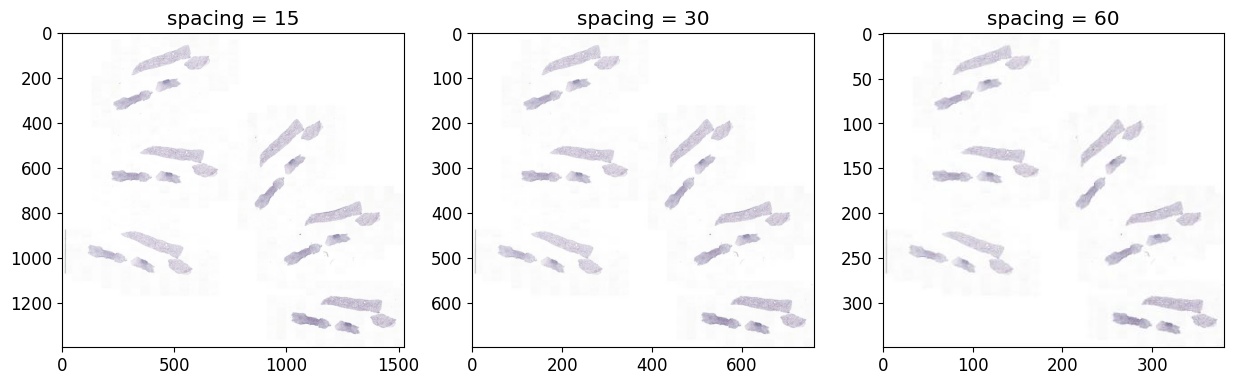

In [16]:
slide_15 = wsi.get_slide(spacing=15)
slide_30 = wsi.get_slide(spacing=30)
slide_60 = wsi.get_slide(spacing=60)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(slide_15)
ax[0].set_title("spacing = 15")
ax[1].imshow(slide_30)
ax[1].set_title("spacing = 30")
ax[2].imshow(slide_60)
ax[2].set_title("spacing = 60")
plt.show()

We can also visualize patches:

In [28]:
x, y = np.round((np.array(wsi.shapes[0]) / 2.2),0)
width, height = 1024, 1024

patch_7 = wsi.get_patch(x=x, y=y, width=width, height=height, spacing=7)
patch_4 = wsi.get_patch(x=x, y=y, width=width, height=height, spacing=4)

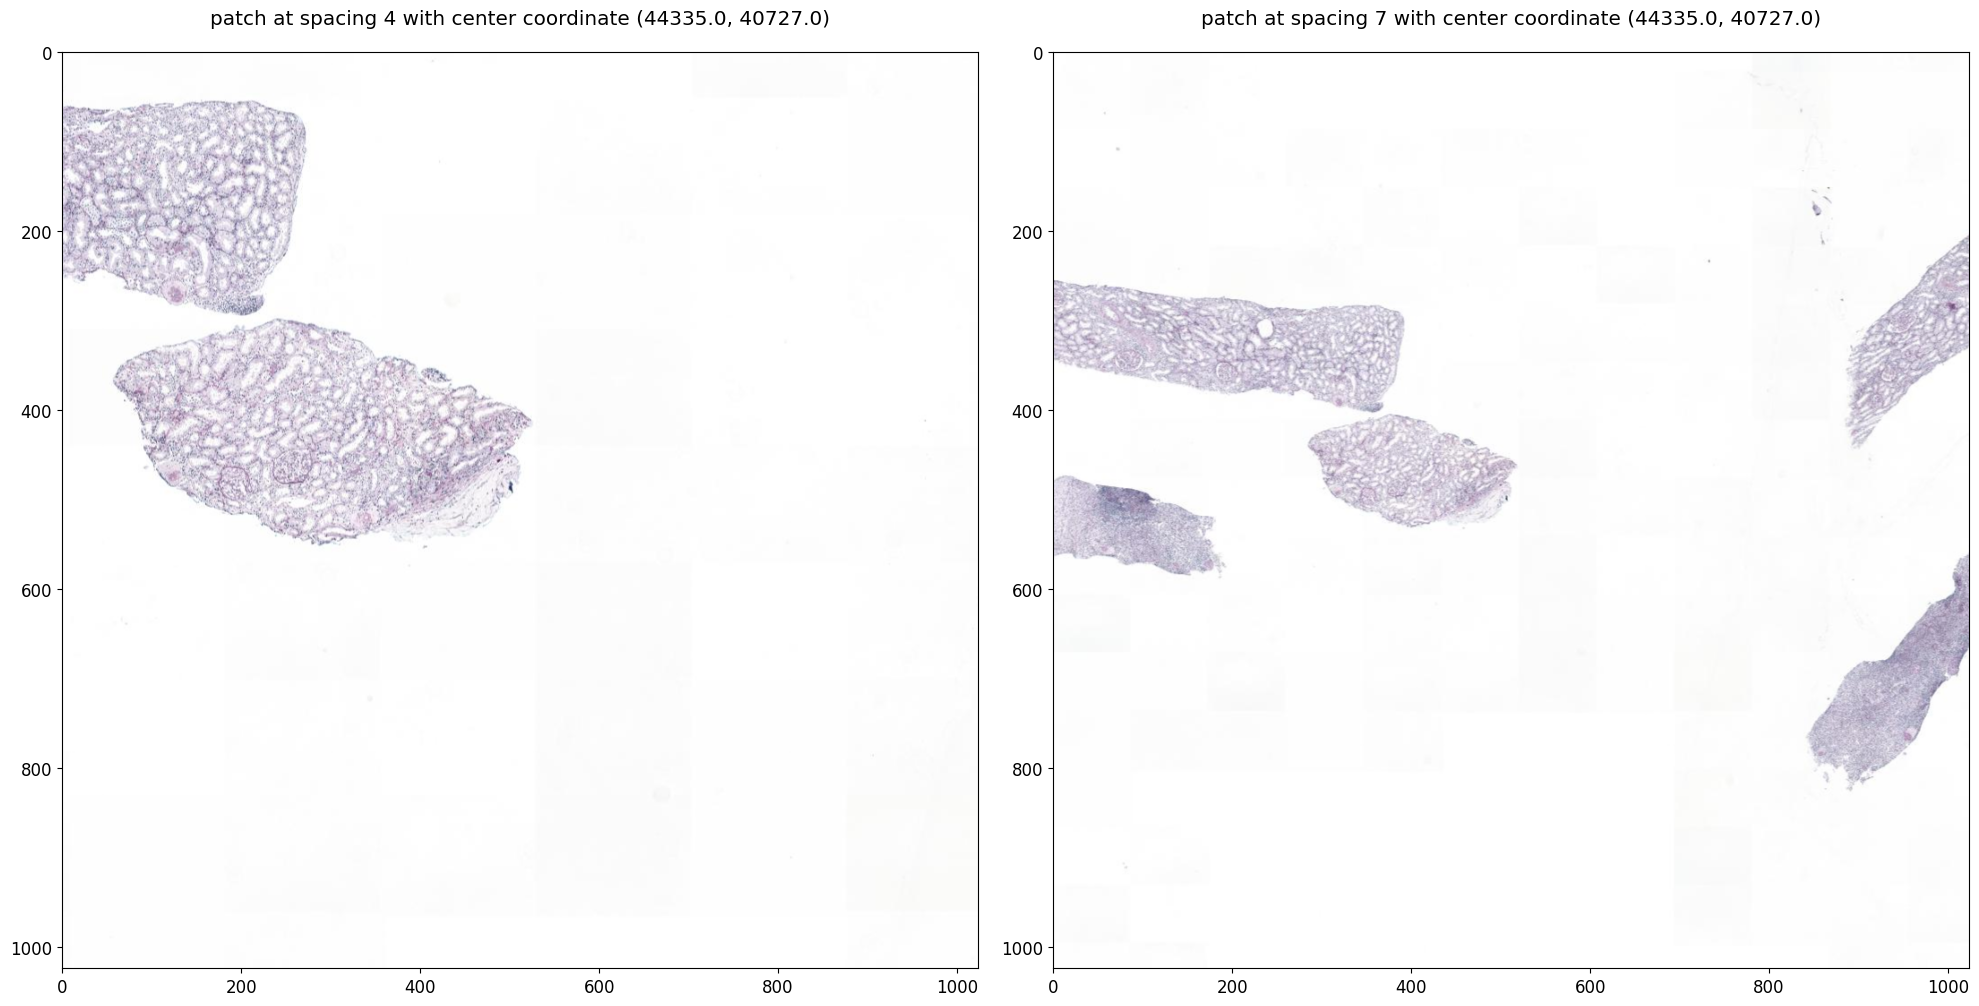

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(patch_4)
axes[0].set_title(f'patch at spacing 4 with center coordinate {x,y}', pad=20)
axes[1].imshow(patch_7)
axes[1].set_title(f'patch at spacing 7 with center coordinate {x,y}', pad=20)
plt.tight_layout()
plt.show()

## Whole Slide Annotation

In [31]:
!pip install colour

In [32]:
from wholeslidedata import WholeSlideAnnotation
from wholeslidedata.visualization.plotting import plot_annotations
from colour import Color
from matplotlib import pyplot as plt

In [33]:
wsa = WholeSlideAnnotation(test_wsa_path)

In [35]:
print(len(wsa.annotations))
print(wsa.labels.names)
color_map = {label_name: Color(pick_for=label_name).hex_l for label_name in wsa.labels.names}
print(color_map)

3821
['lymphocytes', 'monocytes', 'roi']
{'lymphocytes': '#b517cb', 'monocytes': '#c822fd', 'roi': '#abc67f'}


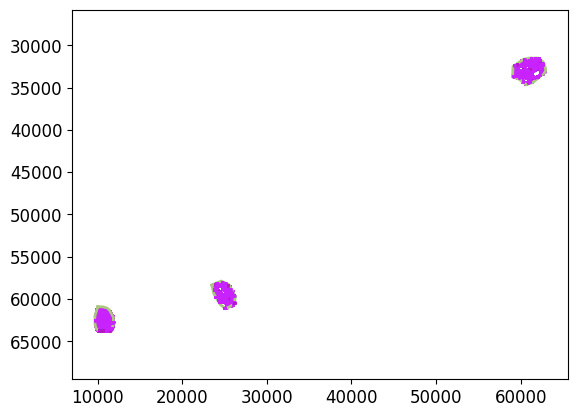

In [38]:
plot_annotations(wsa.annotations, color_map=color_map)